In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import print_function

In [2]:
%%time
train = pd.read_csv('data/train.csv', index_col='ID')
test = pd.read_csv('data/test.csv', index_col='ID')
catcols = train.columns[train.dtypes == 'O']

CPU times: user 3.26 s, sys: 124 ms, total: 3.38 s
Wall time: 4.06 s


In [3]:
%%time
print (train.shape, test.shape)
for i, col in enumerate(catcols):
    #print(i, col, '\t', len(train.loc[:, col].unique()))
    vmap = dict([(train.loc[:, col].unique()[i], i) for i in range(len(train.loc[:, col].unique()))])
    train.loc[:, col + 'n'] = train.loc[:, col].map(vmap)
    test.loc[:, col + 'n'] = test.loc[:, col].map(vmap)

(114321, 132) (114393, 131)
CPU times: user 2min 38s, sys: 813 ms, total: 2min 38s
Wall time: 2min 38s


CPU times: user 2.32 s, sys: 280 ms, total: 2.6 s
Wall time: 2.59 s


In [4]:
for col in catcols:
    print (col, len(pd.unique(train[col])))

v3 4
v22 18211
v24 5
v30 8
v31 4
v47 10
v52 13
v56 123
v66 3
v71 9
v74 3
v75 4
v79 18
v91 8
v107 8
v110 3
v112 23
v113 37
v125 91


In [8]:
len(pd.unique(train['v1']))

64488

In [5]:
train[catcols].isnull().sum()

v3       3457
v22       500
v24         0
v30     60110
v31      3457
v47         0
v52         3
v56      6882
v66         0
v71         0
v74         0
v75         0
v79         0
v91         3
v107        3
v110        0
v112      382
v113    55304
v125       77
dtype: int64

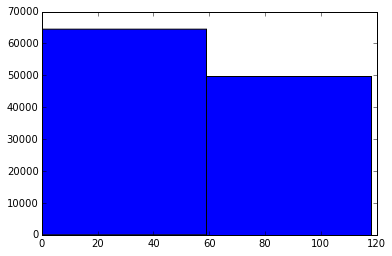

In [6]:
plt.hist(np.array(train.isnull().sum(axis=1)), bins=2);

['v3', 'v22', 'v24', 'v30', 'v31', 'v47', 'v52', 'v56', 'v66', 'v71', 'v74', 'v75', 'v79', 'v91', 'v107', 'v110', 'v112', 'v113', 'v125']
Index([u'v3', u'v22', u'v24', u'v30', u'v31', u'v47', u'v52', u'v56', u'v66',
       u'v71', u'v74', u'v75', u'v79', u'v91', u'v107', u'v110', u'v112',
       u'v113', u'v125'],
      dtype='object')


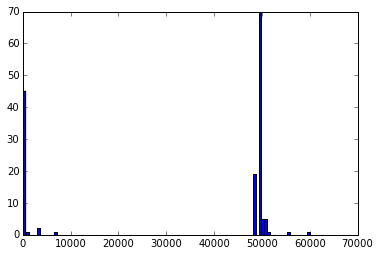

In [7]:
plt.hist(train.isnull().sum(), bins = 100);

In [74]:
#plt.hist(train.v22n.values, bins=20);
zz = len(np.where((train.v22n.value_counts()) > 30)[0])
train.loc[:, 'v22_ncut'] = train.loc[:, 'v22n']
train.v22_ncut[train.v22n.value_counts()) < 30]# = -99*np.ones(zz)

#len(np.where((train.v22_ncut.value_counts()) > 30)[0])

ValueError: Can only tuple-index with a MultiIndex

In [9]:
train.loc[:, 'user_type'] = (train.isnull().sum(axis=1) > 60)

ID
3    False
4     True
5    False
6    False
8     True
Name: user_type, dtype: bool

In [14]:
import csv
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import ensemble
def loadETdata():
    print('Load data...')
    train = pd.read_csv("./data/train.csv")
    test = pd.read_csv("./data/test.csv")
    return train, test

def preprETdata(train, test):
    target = train['target'].values
    train = train.drop(['ID','target','v8','v23','v25','v31','v36','v37','v46','v51','v53','v54','v63','v73','v75','v79','v81','v82','v89','v92','v95','v105','v107','v108','v109','v110','v116','v117','v118','v119','v123','v124','v128'],axis=1)
    id_test = test['ID'].values
    test = test.drop(['ID','v8','v23','v25','v31','v36','v37','v46','v51','v53','v54','v63','v73','v75','v79','v81','v82','v89','v92','v95','v105','v107','v108','v109','v110','v116','v117','v118','v119','v123','v124','v128'],axis=1)
    #train.loc[:, 'user_type'] = (train.isnull().sum(axis=1) > 60)
    #test.loc[:, 'user_type'] = (test.isnull().sum(axis=1) > 60)
    print('Clearing...')
    for (train_name, train_series), (test_name, test_series) in zip(train.iteritems(),test.iteritems()):
        if train_series.dtype == 'O':
            #for objects: factorize
            train[train_name], tmp_indexer = pd.factorize(train[train_name])
            test[test_name] = tmp_indexer.get_indexer(test[test_name])
            #but now we have -1 values (NaN)
        else:
            #for int or float: fill NaN
            tmp_len = len(train[train_series.isnull()])
            if tmp_len>0:
                #print "mean", train_series.mean()
                train.loc[train_series.isnull(), train_name] = -999 
            #and Test
            tmp_len = len(test[test_series.isnull()])
            if tmp_len>0:
                test.loc[test_series.isnull(), test_name] = -999



    return train, target, test


def trainET(X_train, target, X_test):
    print('Training...')
    extc = ExtraTreesClassifier(n_estimators=850,max_features= 60,criterion= 'entropy',min_samples_split= 4,
                                max_depth= 40, min_samples_leaf= 2, n_jobs = -1)      

    extc.fit(X_train,target) 

    print('Predict...')
    y_pred = extc.predict_proba(X_test)
    #print y_pred
    return y_pred


In [ ]:
%%time
#run ET
et_y_pred = trainET(preprETdata(loadETdata()))
pd.DataFrame({"ID": id_test, "PredictedProb": et_y_pred[:,1]}).to_csv('extra_trees.csv',index=False)

In [15]:
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

def shuffle_metric(clf, Xtrain, ytrain, ratio, metric, random_state=42):
    trainX, testX, trainY, testY = train_test_split(Xtrain, ytrain, train_size=ratio, random_state=random_state)
    clf.fit(trainX, trainY)
    return metric(testY, clf.predict_proba(testX))

def zipped_shuffle_metric(args):
    return shuffle_metric(*args)

def random_cross_val(clf, Xtrain, ytrain, ratio, times, metric, random_state = 0, n_jobs=8):
    results = np.empty(0)
    size = len(Xtrain)
    if not size == len(ytrain):
        raise Exception("Different data size")
    results = list()
    for i in range(times):
        print ('\r', i,)
        results.append(shuffle_metric(clf, Xtrain, ytrain, ratio, metric, i + random_state))
        
    return np.array(results)



In [13]:
%load_ext ipytelegram
%telegram_setup 188276417:AAEJD5uwNEmqNb87tVZgI4wb9n9ERNiz4AY 102773555

Installed ipytelegram.py. To use it, type:
  %load_ext ipytelegram


C:\dev\Anaconda\lib\site-packages\IPython\core\magics\extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension(s)as a python packages.
  "as a python packages.", UserWarning)


In [16]:
#SMALL
from sklearn.metrics import log_loss
train = pd.read_csv('data/holdout.csv')
test = pd.read_csv('data/holdout.csv')
Xtrain, ytrain, _ = preprETdata(train, test)


Clearing...


In [17]:
%%time
%%telegram_send Your shit is ready, Sir!
clf = ExtraTreesClassifier(n_estimators=850,max_features= 60,criterion= 'entropy',min_samples_split= 4,
                                max_depth= 40, min_samples_leaf= 2, n_jobs = -1)
print (random_cross_val(clf, Xtrain, ytrain, .7, 10, log_loss).mean())

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
0.481681288601
Wall time: 1min 51s


In [19]:
def ll_tune(data, low, high, low_mul, high_mul):
    def make(x, low, high, low_mul, high_mul):
        if x < low: x = 0.
        elif x > high: x = 1.
        elif x < .5: x *= low_mul
        else: x *= high_mul
        return x
    return np.vectorize(make)(data, low, high, low_mul, high_mul)

a = np.array([.1, .4, .6, .9])
ll_tune(a, .2, .8, .5, .5)

array([ 0. ,  0.2,  0.3,  1. ])

In [25]:
trainX, testX, trainY, testY = train_test_split(Xtrain, ytrain, train_size=0.7, random_state=42)
clf.fit(trainX, trainY)
pred = clf.predict_proba(testX)

In [47]:
%%time
from copy import copy
res = list()
for low in np.linspace(0., .5, 100):
    for high in np.linspace(.5, 1., 100):
        for low_mul in np.linspace(1., 1.5, 50):
            for high_mul in np.linspace(.5, 1., 10):
                res.append((log_loss(testY, ll_tune(copy(pred), low, high, low_mul, high_mul)), (low, high, low_mul, high_mul)))

CPU times: user 3h 27min 53s, sys: 6.03 s, total: 3h 27min 59s
Wall time: 3h 27min 46s


In [48]:
print (log_loss(testY, pred), log_loss(testY, ll_tune(copy(pred), 0, 1, 1, 1)))
for r in sorted(res, key=lambda x: x[0])[:20]:
    print (r) 

0.473614190948 0.473614190948
(0.47264788940843361, (0.015151515151515152, 0.78282828282828287, 1.0, 1.0))
(0.47272544364267838, (0.015151515151515152, 0.78282828282828287, 1.010204081632653, 1.0))
(0.4727518559837206, (0.010101010101010102, 0.78282828282828287, 1.0, 1.0))
(0.47278675495712635, (0.0050505050505050509, 0.78282828282828287, 1.0, 1.0))
(0.47279114798206623, (0.0, 0.78282828282828287, 1.0, 1.0))
(0.47281810690461834, (0.015151515151515152, 0.78282828282828287, 1.0204081632653061, 1.0))
(0.47283046420170277, (0.010101010101010102, 0.78282828282828287, 1.010204081632653, 1.0))
(0.47286571781501641, (0.0050505050505050509, 0.78282828282828287, 1.010204081632653, 1.0))
(0.47287015557694084, (0.0, 0.78282828282828287, 1.010204081632653, 1.0))
(0.47287611570989257, (0.015151515151515152, 0.78787878787878785, 1.0, 1.0))
(0.47289056855409545, (0.015151515151515152, 0.79797979797979801, 1.0, 1.0))
(0.472891132372255, (0.015151515151515152, 0.81818181818181823, 1.0, 1.0))
(0.4729241

In [7]:

from sklearn.dummy import BaseEstimator, ClassifierMixin
import xgboost as xgb
class XGB(BaseEstimator, ClassifierMixin):
    def __init__(self, numround, times=1, **kwargs):
        self.params = kwargs
        self.numround = numround
        self.times = times
    
    def fit(self, X, y):
        Xgbtrain = xgb.DMatrix(data = X, label = y)
        self.clfs = list()
        for i in range(self.times):
            self.params['seed'] += 1
            self.clfs.append(xgb.train(list(self.params.items()), Xgbtrain, self.numround))
        return self
    
    def predict(self, X):
        Xgbtest = xgb.DMatrix(data = X)
        results = list()
        for clf in self.clfs:
            results.append(clf.predict(Xgbtest))
        return np.mean(np.array(results), axis = 0)
    
    def predict_proba(self, X):
        return self.predict(X)
        proba = list()
        proba.append(self.predict(X))
        return np.array(proba)

In [8]:
params = {
    'nthread':-1,
    'eval_metric': 'logloss',
    'eta': .01,
    'max_depth': 11,
    'subsample': .96,
    'colsample_bytree': .45,
    'colsample_bylevel': 1,
    'lambda': 1,
    'alpha': 0,
    'objective': 'binary:logistic',
    'seed': 42, 
    'silent': 0,
}

In [73]:
%%time
clf = XGB(500, 1,  **params)
print (random_cross_val(clf, Xtrain, ytrain, .7, 10, log_loss).mean())

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
0.462206476573
CPU times: user 48min 29s, sys: 5.91 s, total: 48min 35s
Wall time: 48min 32s


In [11]:
import time, sys
from sklearn.cross_validation import KFold
def true_stack(Xtrain, ytrain, Xtest, clfs1, clf2, folds=5):
    print(Xtrain.shape, ytrain.shape, Xtest.shape)
    #ft2size = np.zeros((1, ytrain.shape[0]))
    phase2_train = np.zeros((0, len(clfs1)))
    st = time.time()
    print ('Fit clfs1')
    sys.stdout.flush()
    for train, test in KFold(len(Xtrain), n_folds=folds):
        X_train = Xtrain[train]
        X_test = Xtrain[test]
        y_train, y_test = ytrain[train], ytrain[test]
        fold_pred = np.zeros((y_test.shape[0], 0))
        for clf in clfs1:
            print (time.time() - st, 'fitting clf1')
            sys.stdout.flush()
            clf.fit(X_train, y_train)
            print(fold_pred.shape, clf.predict(X_test).shape)
            fold_pred = np.hstack((fold_pred, clf.predict(X_test).reshape((fold_pred.shape[0], 1))))
        phase2_train = np.vstack((phase2_train, fold_pred))
    print (time.time() - st, 'CLF2')
    clf2.fit(phase2_train, ytrain)
    phase2_test = np.zeros((len(Xtest), 0))
    for clf in clfs1:
        print (time.time() - st, 'refitting clf1')
        sys.stdout.flush()
        clf.fit(Xtrain, ytrain)
        phase2_test = np.hstack((phase2_test, clf.predict(Xtest).reshape((phase2_test.shape[0], 1))))
    return clf2.predict(phase2_test)

In [17]:
%%time
from sklearn.linear_model import LinearRegression as LR
trainX, testX, trainY, testY = train_test_split(Xtrain.values, ytrain, train_size=.7, random_state=43)
clfs1 = [XGB(500, 3,  **params), ExtraTreesClassifier(n_estimators=850,max_features= 60,criterion= 'entropy',min_samples_split= 4,
                                max_depth= 40, min_samples_leaf= 2, n_jobs = -1)]
clf2 = LR()
print(trainY.shape)
stpred = true_stack(trainX, trainY, testX, clfs1, clf2, 3)
print (log_loss(testY, stpred))

(80024,)
(80024, 100) (80024,) (34297, 100)
Fit clfs1
0.0158920288086 fitting clf1
(26675, 0) (26675,)
570.812372923 fitting clf1
(26675, 1) (26675,)
727.955374956 fitting clf1
(26675, 0) (26675,)
1295.01817703 fitting clf1
(26675, 1) (26675,)
1450.80279398 fitting clf1
(26674, 0) (26674,)
2015.62945795 fitting clf1
(26674, 1) (26674,)
2168.33659601 CLF2
2168.34070301 refitting clf1
3022.27121305 refitting clf1
0.46453279891
CPU times: user 2h 17min 3s, sys: 9.57 s, total: 2h 17min 13s
Wall time: 54min 41s


In [19]:
%%time
trainX, testX, trainY, testY = train_test_split(Xtrain, ytrain, train_size=0.7, random_state=42)
clf.fit(trainX, trainY)
pred = clf.predict_proba(testX)

Wall time: 10.6 s


In [26]:
def power_tune(data, th, power):
    data[np.abs(data - .5) > th - .5] = ((np.abs(data - .5) ** power) * np.sign(data - .5) + .5)[np.abs(data - .5) > th - .5]
    return data

a = np.array([.1, .4, .6, .9, 0., .9999])
power_tune(a, .8, 1.01)

array([ 0.10364842,  0.4       ,  0.6       ,  0.89635158,  0.00345375,
        0.99644595])

In [ ]:
%%time
from copy import copy
res = list()
for p in np.linspace(1., 1.1, 1000):
    for th in np.linspace(.95, 1., 100):
        res.append((log_loss(testY, power_tune(copy(pred), th, p)), (p, th)))

In [ ]:
%%telegram_send Yarrr!
print ('', log_loss(testY, pred))
for r in sorted(res, key=lambda x: x[0])[:40]:
    print (r) 